## <center>Churn Modelling, Prezentacja<center/>
<center>Projekt zaliczeniowy Praktyczny Machine Learning w Pythonie <br/>
Autor: Maciej Odziemczyk (388581)<br/>
Wydział Nauk Ekonomicznych UW<br/>
czerwiec 2020 <center/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import spearmanr
from hpl import subplotShape, plotROCsPRs

In [2]:
df = pd.read_csv("Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


##### Zmienne (11): 
 - CreditScore: ciągła,
 - Age: ciągła,
 - Balance: ciągła,
 - EstimatedSalary: ciągła,
 - Geography: dyskretna, poziomy: Germany, Spain, France,
 - Gender: dyskretna, poziomy: Male, Female,
 - Tenure: liczebnościowa uporządkowana, zakres 1-10 (ile czasu obiekt jest klientem),
 - NumOfProducts: liczebnościowa uporządkowana, zakres 1-4,
 - HasCrCard: dyskretna,
 - IsActiveMember: dyskretna,
 - Exited: dyskretna, target, churn albo nie.

Nie ma nulli: True


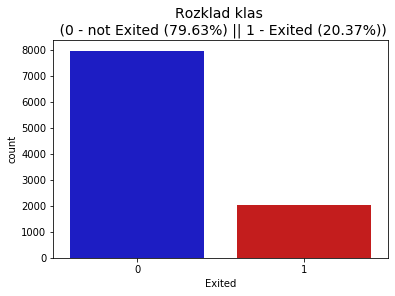

In [3]:
# usuwanie atrybutów bezpośrednio identyfikujących obserwacje
df.drop(labels = ['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace = True)
# sprawdzenie czy rzeczywiście nie ma braków danych
print('Nie ma nulli: {}'.format(df.dropna().shape == df.shape))
# zmienne numeryczne
num = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

# rozkład etykiet - balans 
colors = ["#0101DF", "#DF0101"]

sns.countplot('Exited', data = df, palette = colors)
plt.title('Rozklad klas \n (0 - not Exited ({}%) || 1 - Exited ({}%))'.format(
    round((df.Exited.value_counts()[0]/df.shape[0])*100, 2),
    round((df.Exited.value_counts()[1]/df.shape[0])*100, 2)),
          fontsize=14)
plt.show()

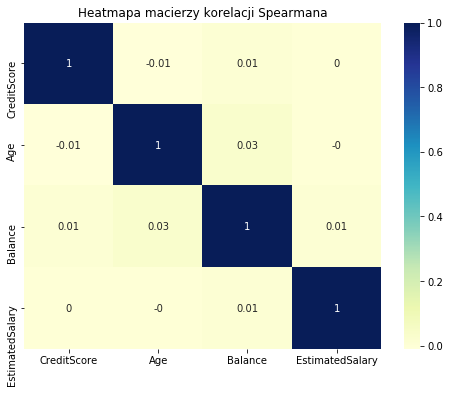

In [4]:
plt.figure(figsize=(8,6))

correl = np.round(df[num].corr(method = 'spearman'), 2)
sns.heatmap(correl, cmap="YlGnBu", annot=True, cbar=True)
plt.title('Heatmapa macierzy korelacji Spearmana')
plt.show()

#### Kolejność chronologiczna prac
##### Notatnik I (Pierwszy Logit, Random Forest, XGB):
 - wstępna obróbka danych,
     - usunięcie zmiennych identyfikujących obserwacje (RowNumber, CustomerID, Surname - dyskusyjne),
     - zbadanie bilansowania zbioru i korelacji zmiennych ciągłych - dobór stosownych wariantów walidacyjnych:
         - warstwowa walidacja krzyżowa, AUC-PR jako główna metryka, ROC-AUC jako poboczna,
 - pierwszy model - logit,
 - sprawdzenie możliwości zbioru danych - Random Forest i XGboost,
     - RF i XGB wymagały specjalnego przygotowania danych - label encoding,
     - praca z RF i XGB:
         - "suche przebiegi",
         - weryfikacja wrażliwości na hiperparametry, sekwencyjny dobór i zawężenie zakresów optymalnych,
         - random search,
         - feature importance, feature selection, wstępne feature engenieering (logarytmy, prosta decylyzacja).
         
Ciekawostka:

In [5]:
with open("model_logit_00.p", "rb") as fp:
    logit_00 = pickle.load(fp)
    
with open("model_RF_02.p", "rb") as fp:
    RF_02 = pickle.load(fp)

In [6]:
print('wyniki pierwszego logitu jako średnia z foldów: \nROC: {}, \nPR: {}'.format(
    np.mean(logit_00['ROCtestResults']),
    np.mean(logit_00['PRtestResults'])
))

print('\nwyniki najlepszego lasu losowego jako średnia z foldów: \nROC: {}, \nPR: {}'.format(
    np.mean(RF_02['ROCtestResults']),
    np.mean(RF_02['PRtestResults'])
))


wyniki pierwszego logitu jako średnia z foldów: 
ROC: 0.7648486062899543, 
PR: 0.4695414516144849

wyniki najlepszego lasu losowego jako średnia z foldów: 
ROC: 0.8617968197816749, 
PR: 0.6954932334652437


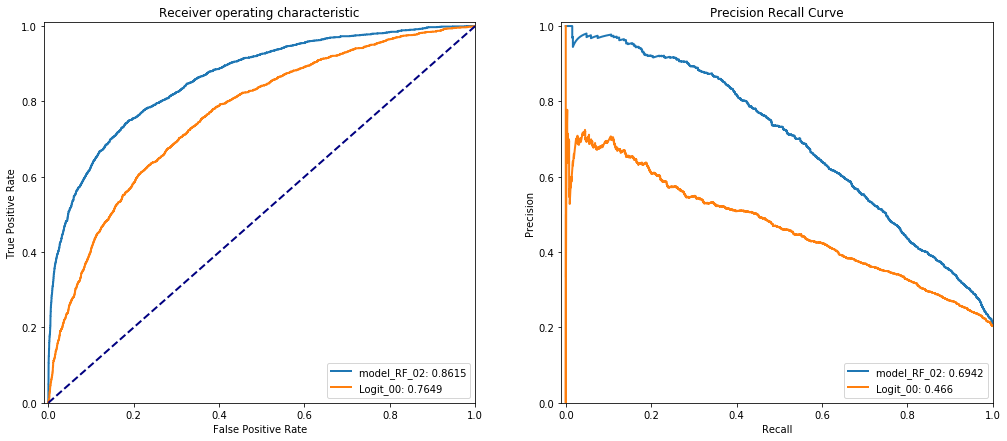

In [7]:
res2plot = []
true = df.Exited.astype(int).sort_index()

for result in [RF_02, logit_00]:
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
plotROCsPRs(res2plot)

Wyniki są różne, z literatury można dowiedzieć się, że w takim przypadku lepiej stosować średnią średnich z foldów (mniej obciążony w stosunku do ground truth wynik). <br/>
George Forman, Martin Scholz - "Apples-to-Apples in Cross-Validation Studies: Pitfalls in Classifier Performance Measurement"
#### Kolejność chronologiczna prac c.d.
##### Notatnik II (Pogłębione EDA, feature engineering, powrót do logitu, RF, XGB):
 - Dogłębne EDA:
     - analiza rozkładów każdej zmiennej, inżynieria:
         - logarytmowanie,
         - podział zmiennych ciągłych na kwartyle, decyle, ekspercki, "ewolucyjny",
         - badanie tablic liczebnościowych (na prawdopodobieństwach) dla zmiennych dyskretnych, w tym uzyskanych z powyższego punktu,
         - badanie interakcji Geography ze zmiennyhmi Age, EstimatedSalary, Balance,
         - normalizacja zmiennych ciągłych, unitaryzacja Tenure,
         - feature selection w oparciu o tablicę Mutable Information, Korelacji Spearmana, procedury od ogółu do szczegółu,
 - Ponowne szacowanie logitu, na nowych zmiennych (nieudane próby regularyzacji) **Uzyskanie wyników zbliżonych do Random Forest! ROC + 0.08, PR + 0.2**,
 - Próby z SVM i KNN (nieudane),
 - Weryfikacja hipotezy o nieprzydatności inżynierii zmiennych w przypadku algorytmów opartych o drzewa decyzyjne (XGB),
 - **Nowe zmienne:**
     - logarytm Age,
     - Geography tylko dla Niemców (scalenie Hiszpanii i Francji),
     - binaryzacja NumOfProducts,
     - podział wieku na kategorie:
         - 40-50,
         - 50-65,
         - 50-65,
         - \>65,
     - pierwsze 2 decyle CreditScore,
     - Balance > 0,
 - **Usunięte zmienne:**
     - HasCrCard,
     - CreditScore,
     - podział wieku w kategorii 35-40,
     - decyle 3, 4, 5, 9 i 10 Credit Score,
     - (filanie 15 zmiennych).
     
##### Finalny i standardowy (po normalizacji) DataFrame są zapisywane jako pickle i wykorzystywane w następnym notatniku!
 
Przykładowa analiza:

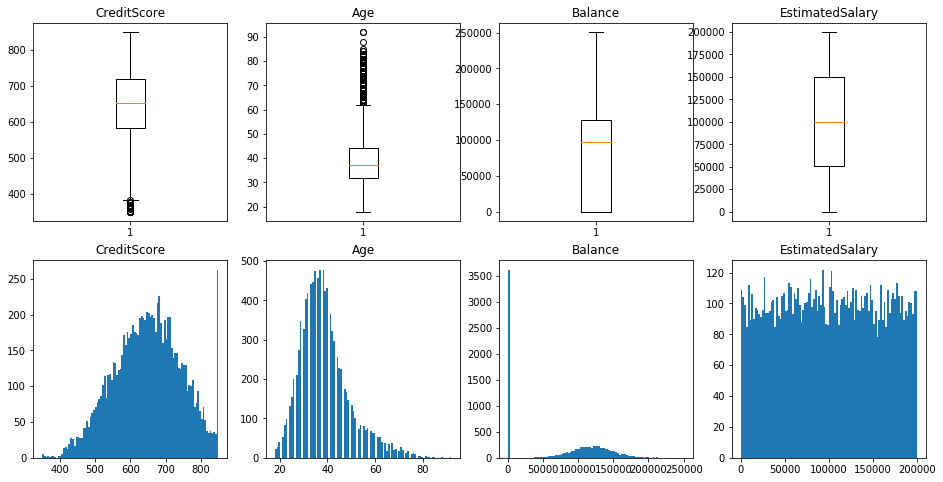

,CreditScore,Age,Balance,EstimatedSalary
count,10000.00,10000.00,10000.00,10000.00
mean,650.53,38.92,76485.89,100090.24
std,96.65,10.49,62397.41,57510.49
min,350.00,18.00,0.00,11.58
25%,584.00,32.00,0.00,51002.11
50%,652.00,37.00,97198.54,100193.92
75%,718.00,44.00,127644.24,149388.25
max,850.00,92.00,250898.09,199992.48


In [8]:
# zwrot macierzy rozmiaru subplotów
rozmiar = subplotShape(np.array(num), 4)

# dodanie wiersza do macierzy
f, ax = plt.subplots(nrows = rozmiar[0]*2, ncols = rozmiar[1], figsize = (16, 8))
# technikalnia (wektory są zerowymiarowe)
ax = ax.reshape(-1, rozmiar[1])

# pętla rysująca wykresy
flag = 0
for r in range(rozmiar[0]):
    for c in range(rozmiar[1]):
        # widoczne tylko pola z wykresami
        ax[r, c].set_visible(False)
        ax[r+1, c].set_visible(False)
        # gdyby pól było więcej niż wykresów
        try:
            # rysowanie
            ax[r, c].boxplot(df[num[flag]])
            ax[r,c].set_title(num[flag])
            ax[r+1, c].hist(df[num[flag]], bins = 100)
            ax[r+1,c].set_title(num[flag])
            flag += 1
            ax[r, c].set_visible(True)
            ax[r+1, c].set_visible(True)
        except:
            pass

plt.show()
# statystyki opisowe
display(np.round(df[num].describe(), 2))

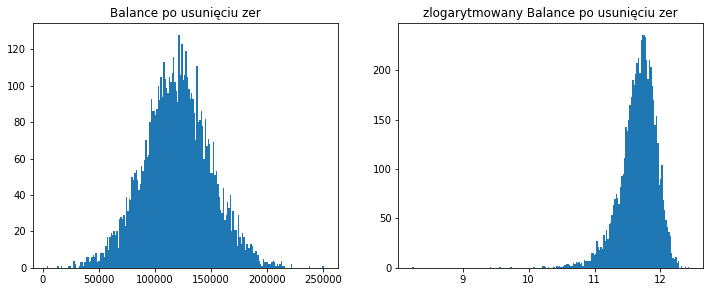

count      6383.00
mean     119827.49
std       30095.06
min        3768.69
25%      100181.98
50%      119839.69
75%      139512.29
max      250898.09
Name: Balance, dtype: float64

In [9]:
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4.5))
ax[0].hist(df.Balance.where(df.Balance > 0).dropna(), bins = 200)
ax[0].set_title('Balance po usunięciu zer')
ax[1].hist(np.log(np.array(df.Balance.where(df.Balance > 0).dropna())), bins = 200)
ax[1].set_title('zlogarytmowany Balance po usunięciu zer')

plt.show()
display(round(df.Balance.where(df.Balance > 0).dropna().describe(), 2))

In [10]:
print('---Decyle EstimatedSalary---')
for d in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    print('decyl {}: {}'.format(int(d*10), round(df.EstimatedSalary.quantile(q = d)), 2))
print('-'*20)
print('Min (niezaokrąglony): {}'.format(df.EstimatedSalary.min()))
print('-'*20)
print('Max (niezaokrąglony): {}'.format(df.EstimatedSalary.max()))
print('-'*20)

---Decyle EstimatedSalary---
decyl 1: 20274.0
decyl 2: 41051.0
decyl 3: 60736.0
decyl 4: 80238.0
decyl 5: 100194.0
decyl 6: 119710.0
decyl 7: 139432.0
decyl 8: 159837.0
decyl 9: 179675.0
decyl 10: 199992.0
--------------------
Min (niezaokrąglony): 11.58
--------------------
Max (niezaokrąglony): 199992.48
--------------------


In [11]:
# podział
df["AgeCut35405065"] = pd.cut(df["Age"], 
       [18.0, 35.0, 40.0, 50.0, 65.0, 100.0], 
       labels = ['<35', '35<x<40', '40<x<50', '50<x<65', '>65'])

# tablica liczebności
ageCut35405065Exited = pd.crosstab(df.AgeCut35405065, df.Exited)

# prawdopodobieństwa
ageCut35405065Exited['prob'] = ageCut35405065Exited[1]/(ageCut35405065Exited[1]+ageCut35405065Exited[0])
ageCut35405065Exited

Exited,0,1,prob
AgeCut35405065,,,
<35,3786,345,0.083515
35<x<40,1927,339,0.149603
40<x<50,1532,788,0.339655
50<x<65,469,528,0.529589
>65,229,35,0.132576


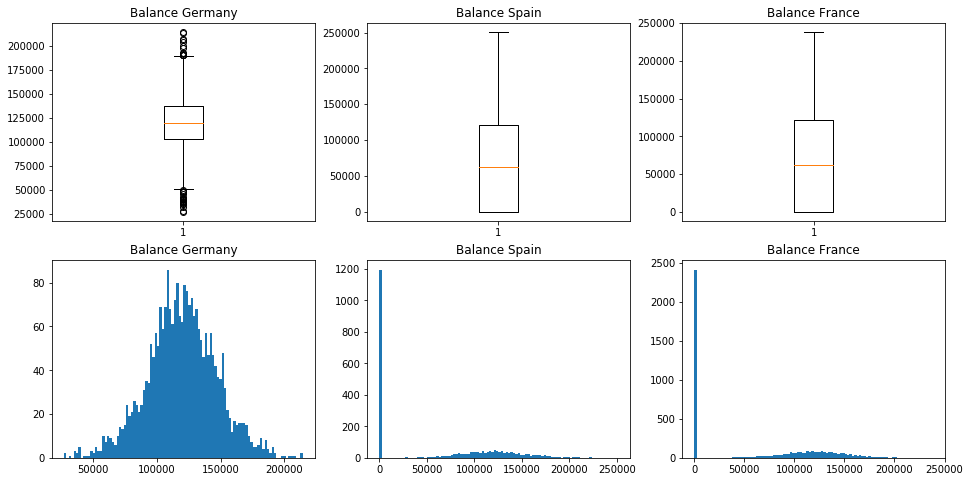

In [12]:
# podział zbioru danych na podzbiory geograficzne
dfGermany = df.where(df.Geography == 'Germany').dropna()
dfSpain = df.where(df.Geography == 'Spain').dropna()
dfFrance = df.where(df.Geography == 'France').dropna()

# Balance
rozmiar = (1,3)

f, ax = plt.subplots(nrows = rozmiar[0]*2, ncols = rozmiar[1], figsize = (16, 8))

ax[0,0].boxplot(dfGermany.Balance)
ax[1,0].hist(dfGermany.Balance, bins = 100)
ax[0,0].set_title('Balance Germany')
ax[1,0].set_title('Balance Germany')

ax[0,1].boxplot(dfSpain.Balance)
ax[1,1].hist(dfSpain.Balance, bins = 100)
ax[0,1].set_title('Balance Spain')
ax[1,1].set_title('Balance Spain')



ax[0,2].boxplot(dfFrance.Balance)
ax[1,2].hist(dfFrance.Balance, bins = 100)
ax[0,2].set_title('Balance France')
ax[1,2].set_title('Balance France')

plt.show()

#### Kolejność chronologiczna prac c.d.
##### Notatnik III (Sieci neuronowe i model finalny)
 - wykorzystanie zbiorów danych z Notatnika II, label encoding tam gdzie to konieczne,
 - porównanie sieci neuronowych na zmiennych standardowych i będących wynikiem Notatnika II (poprawa wyników o kilka %),
 - praca z sieciami neuronowymi w zakresie pokazanym na zajęciach:
     - zbadanie przebiegu procesu uczenia w zależności od optymalizatora,
     - zbadanie przebiegu procesu uczenia w zależności od batch size,
     - zbadanie przebiegu procesu uczenia w zależności od funkcji aktywacji,
     - zbadanie przebiegu procesu uczenia w zależności od zastosowanej regularyzacji,
     - zbadanie przebiegu procesu uczenia w zależności od zastosowanego dropoutu,
     - walidacja krzyżowa i wybór najlepszej sieci,
 - zestawienie wyników wszystkich modeli (bez KNN i SVM - były zbyt słabe i nie zostało im poświęcone dużo uwagi),
 - sprawdzenie zróżnicowania predykcji dokonywanych przez najlepsze modele,
 - regresja logistyczna targetu na predykcjach z modeli,
 - ensembling:
     - próba zwykłej średniej (nieudana),
     - symulacja po zawężeniu wag, 10 000 iteracji losowych wag.

Wyniki:

In [13]:
with open("model_logit_01.p", "rb") as fp:
    logit_01 = pickle.load(fp)

with open("model_RF_00.p", "rb") as fp:
    RF_00 = pickle.load(fp)
    
with open("model_RF_01.p", "rb") as fp:
    RF_01 = pickle.load(fp)
    
with open("model_XGB_00.p", "rb") as fp:
    XGB_00 = pickle.load(fp)
    
with open("model_XGB_01.p", "rb") as fp:
    XGB_01 = pickle.load(fp)
    
with open("model_NN_00.p", "rb") as fp:
    NN_00 = pickle.load(fp)
    
results = pd.DataFrame(columns = ['model', 'ROCtest', 'PRtest', 'PrzetrenowanieROC', 'PrzetrenowaniePR'])
for i in [logit_00, logit_01, RF_00, RF_01, RF_02, XGB_00, XGB_01, NN_00]:
    results = results.append(
        pd.DataFrame(
            np.array([
                i['name'],
                round(np.mean(i['ROCtestResults']), 4),
                round(np.mean(i['PRtestResults']), 4),
                round(np.mean(i['ROCtrainResults'])-np.mean(i['ROCtestResults']), 4),
                round(np.mean(i['PRtrainResults'])-np.mean(i['PRtestResults']), 4)
            ]).reshape(1,-1),
            columns = results.columns.tolist()),
        ignore_index = True)
    
results.sort_values(by = 'PRtest', ascending=False)

,model,ROCtest,PRtest,PrzetrenowanieROC,PrzetrenowaniePR
6,model_XGB_01,0.8705,0.7158,0.0358,0.0627
5,model_XGB_00,0.8688,0.713,0.0451,0.0746
7,model_NN_00,0.8652,0.7055,0.0113,0.0196
4,model_RF_02,0.8618,0.6955,0.071,0.1168
3,model_RF_01,0.8593,0.6937,0.0446,0.0763
2,model_RF_00,0.8485,0.6709,0.1515,0.3291
1,model_logit_01,0.8463,0.667,0.0017,0.0018
0,Logit_00,0.7648,0.4695,0.0029,0.0005


##### Wyniki ensemblingu:

In [14]:
with open("symulacja.p", "rb") as fp:
    symulacja = pickle.load(fp)

display(symulacja.sort_values(by = 'PR', ascending = False).head(10))

,a,b,c,d,ROC,PR
6553,0.0,0.0,44.0,98.0,0.870459,0.714516
6586,1.0,0.0,40.0,95.0,0.870437,0.714486
1838,0.0,2.0,41.0,99.0,0.870450,0.714451
7287,0.0,2.0,42.0,97.0,0.870438,0.714409
7289,0.0,0.0,43.0,85.0,0.870399,0.714366
2097,2.0,0.0,45.0,99.0,0.870373,0.714359
9435,1.0,3.0,41.0,100.0,0.870406,0.714350
5473,2.0,2.0,40.0,99.0,0.870393,0.714345
7870,1.0,2.0,41.0,94.0,0.870404,0.714341
6332,0.0,3.0,42.0,96.0,0.870418,0.714339


Legenda:
 - a - waga Logitu,
 - b - waga Random Forest,
 - c - waga Sieci Neuronowej,
 - d - waga XGB.
 
##### Wnioski:
Najlepszym rozwiązaniem problemu okazał się XGB na standardowych zmiennych. Poparcia nieprzydatności inżynierii można szukać w wynikach istotności kolumn (hiperparametr XGB) - na standardowych zmiennych 0.9, na nowych spadek do 0.5-0.7. Sieci Neuronowe były drugim najlepszym algorytmem, co prawda metryki nie były dużo wyższe niż w przypadku Random Forest (III najlepszy algorytm), ale w tym problemie ważna była metryka PR, a sieci miały na niej 10-cio krotnie mniejsze przetrenowanie. Bardzo możliwe, że z sieci neuronowych można wycisnąć znacznie więcej niż zostało to zrobione w niniejszym projekcie, podczas gdy Random Forest i XGB to algorytmy proste w obsłudze i jak pokazały eksperymenty, odporne na przeprowadzoną inżynierię. Najgorsze wyniki uzyskano na logicie, jednak na nim zaobserwowano kolosalną poprawę po manipulacji danymi i wyniki stały się porównywalne z Random Forest, jednocześnie zaletą logitu jest to, że jest transparenty co do swoich parametrów, które również można zinterpretować jako ilorazy szans lub efekty cząstkowe, zatem może być on wykorzystywany na produkcji w miejscu, gdzie trzeba trzeba będzie komuś wytłumaczyć wpływ zmiennej na prawdopodobieńśtwo churnu. 